# Install essential python packages

In [1]:
!pip install -q timm albumentations wandb

     |████████████████████████████████| 549 kB 6.8 MB/s 
     |████████████████████████████████| 1.9 MB 45.4 MB/s 
     |████████████████████████████████| 182 kB 67.2 MB/s 
     |████████████████████████████████| 182 kB 67.4 MB/s 
     |████████████████████████████████| 168 kB 71.3 MB/s 
     |████████████████████████████████| 62 kB 868 kB/s 
     |████████████████████████████████| 168 kB 55.5 MB/s 
     |████████████████████████████████| 166 kB 60.1 MB/s 
     |████████████████████████████████| 166 kB 53.9 MB/s 
     |████████████████████████████████| 162 kB 72.4 MB/s 
     |████████████████████████████████| 162 kB 62.8 MB/s 
     |████████████████████████████████| 158 kB 44.6 MB/s 
     |████████████████████████████████| 157 kB 70.5 MB/s 
     |████████████████████████████████| 157 kB 70.5 MB/s 
     |████████████████████████████████| 157 kB 69.4 MB/s 
     |████████████████████████████████| 157 kB 78.5 MB/s 
     |████████████████████████████████| 157 kB 37.0 MB/s 
     |███████████

In [2]:
!pip install catalyst

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 446 kB 3.8 MB/s 
     |████████████████████████████████| 191 kB 4.7 MB/s 
     |████████████████████████████████| 125 kB 15.4 MB/s 


# Import essential python packages

In [3]:
from glob import glob
from sklearn.model_selection import GroupKFold
import torch
from torch import nn
import torch.nn.functional as F
import os
import time
from datetime import datetime
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
import wandb
import timm
import shutil
from catalyst.data.sampler import BalanceClassSampler
import warnings

warnings.filterwarnings(action='ignore')

# Hyper-parameter setting

In [4]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [5]:
#압축파일 그대로 올리는 경우 해당 경로에 압축해제
!unzip -qq '/gdrive/My Drive/image-anomaly-detection.zip'

In [6]:
args = {
    'model_name': 'tf_efficientnet_b0_ns',  # 신경망 구조
    'lr': 1e-3,  # 학습률
    'weight_decay': 0,  # 가중치 감쇠
    'drop_rate': 0.2,  # 학습 시 dropout 비율
    'image_size': 256,  # 이미지 크기
    'num_epochs': 50,  # 학습 반복수
    'batch_size': 16,  # 미니배치 크기
    'num_classes': 2,  # 판별할 클래스 개수
    'num_folds': 5,  # 데이터셋 분할 fold 개수
    'val_fold': 0,  # 검증용 fold 선택
    'seed': 42,  # 랜덤 seed 설정
    'log_step': 50,  # log 남길 iteration 반복 수
    'model_save_step': 5,  # model 저장할 epoch 반복 수
    'workspace_path': '/content',  # 작업 위치
    'checkpoint_dir': './checkpoints',  # 모델 저장 디렉토리
    'pretrained_name': 'tf_efficientnet_b0_ns_model_best.pth',  # 학습한 모델 파일이름 (.pth까지 붙이기)
}

TRAIN_DATA_ROOT_PATH = os.path.join(args['workspace_path'], 'train')
TEST_DATA_ROOT_PATH = os.path.join(args['workspace_path'], 'test')

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(43)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
#wandb 본인 것과 연동할 것
wandb.init(project="AI_termpj", entity="ahnheejin")
wandb.run.name = 'steganalysis(classification)'

#49ff65b49a1f8876df8c18711047d04518eee687

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# GroupKFold splitting

In [10]:
dataset = []

for label, kind in enumerate(['cover', 'stego']):
    for path in glob(f'{TRAIN_DATA_ROOT_PATH}/{kind}/*.png', recursive=True):
        dataset.append({
            'kind': kind,
            'image_name': path.replace('\\', '/').split('/')[-1],
            'label': label
        })

random.shuffle(dataset)
dataset = pd.DataFrame(dataset)

gkf = GroupKFold(n_splits=args['num_folds'])

dataset.loc[:, 'fold'] = 0
for fold_number, (train_index, val_index) in enumerate(gkf.split(X=dataset.index, y=dataset['label'], groups=dataset['image_name'])):
    dataset.loc[dataset.iloc[val_index].index, 'fold'] = fold_number

In [11]:
dataset.head()

,kind,image_name,label,fold
0,stego,03724.png,1,4
1,stego,03429.png,1,2
2,stego,05056.png,1,1
3,stego,00647.png,1,3
4,stego,00873.png,1,0


# Dataset

In [12]:
class DatasetRetriever(Dataset):
    def __init__(self, kinds, image_names, labels, transforms=None):
        super().__init__()
        self.kinds = kinds
        self.image_names = image_names
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, index: int):
        kind, image_name, label = self.kinds[index], self.image_names[index], self.labels[index]
        image_path = f'{TRAIN_DATA_ROOT_PATH}/{kind}/{image_name}'.replace('\\', '/')
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image[:,:,1]=0
        image[:,:,2]=0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
            
        return image, label

    def __len__(self) -> int:
        return self.image_names.shape[0]

    def get_labels(self):
        return list(self.labels)

# Simple Augmentations: Flips

In [13]:
def get_train_transforms():
    return A.Compose([
            A.RandomRotate90(p=0.5),
            A.Cutout(num_holes=8, max_h_size=15, max_w_size=15, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            ToTensorV2(p=1.0)
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            ToTensorV2(p=1.0)
        ], p=1.0)

In [14]:
train_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] != args['val_fold']].kind.values,
    image_names=dataset[dataset['fold'] != args['val_fold']].image_name.values,
    labels=dataset[dataset['fold'] != args['val_fold']].label.values,
    transforms=get_train_transforms(),
)

validation_dataset = DatasetRetriever(
    kinds=dataset[dataset['fold'] == args['val_fold']].kind.values,
    image_names=dataset[dataset['fold'] == args['val_fold']].image_name.values,
    labels=dataset[dataset['fold'] == args['val_fold']].label.values,
    transforms=get_valid_transforms(),
)

In [15]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=args['batch_size'],
        pin_memory=False,
        drop_last=True,
    )
val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=args['batch_size'],
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

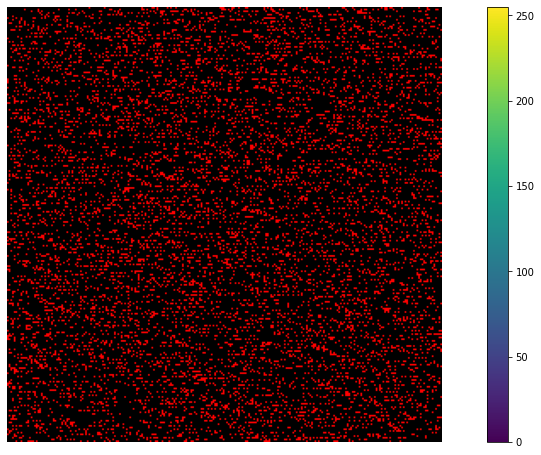

In [17]:
cover_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', '00001.png'), cv2.IMREAD_COLOR)
cover_image = cv2.cvtColor(cover_image, cv2.COLOR_BGR2RGB)
stego_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'stego', '00001.png'), cv2.IMREAD_COLOR)
stego_image = cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB)
difference = np.abs(cover_image - stego_image)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
im = ax.imshow(difference, vmin=0, vmax=255)
fig.colorbar(im)
plt.show()

In [ ]:
cover_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', '00001.png'), cv2.IMREAD_COLOR)
cover_image = cv2.cvtColor(cover_image, cv2.COLOR_BGR2RGB)
cover_image[:,:,0]=0
cover_image[:,:,2]=0

stego_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'stego', '00001.png'), cv2.IMREAD_COLOR)
stego_image = cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB)
stego_image[:,:,0]=0
stego_image[:,:,2]=0


difference = np.abs(cover_image - stego_image)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
im = ax.imshow(difference, vmin=0, vmax=255)
fig.colorbar(im)
plt.show()

In [ ]:
cover_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'cover', '00001.png'), cv2.IMREAD_COLOR)
cover_image = cv2.cvtColor(cover_image, cv2.COLOR_BGR2RGB)
cover_image[:,:,0]=0
cover_image[:,:,1]=0

stego_image = cv2.imread(os.path.join(TRAIN_DATA_ROOT_PATH, 'stego', '00001.png'), cv2.IMREAD_COLOR)
stego_image = cv2.cvtColor(stego_image, cv2.COLOR_BGR2RGB)
stego_image[:,:,0]=0
stego_image[:,:,1]=0


difference = np.abs(cover_image - stego_image)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.set_axis_off()
im = ax.imshow(difference, vmin=0, vmax=255)
fig.colorbar(im)
plt.show()

In [18]:
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler=BalanceClassSampler(labels=train_dataset.get_labels(), mode="downsampling"),
        batch_size=args['batch_size'],
        pin_memory=False,
        drop_last=True,
    )
val_loader = torch.utils.data.DataLoader(
        validation_dataset,
        batch_size=args['batch_size'],
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
    )

# Metrics

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, label, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = label.size(0)

    _, pred = output.topk(maxk, 1, True, True)  # prediction: select k maximum at each output
    pred = pred.t()
    correct = pred.eq(label.view(1, -1).expand_as(pred))
    acc = correct.view(-1).float().sum(0, keepdim=True).mul_(100.0 / batch_size)  # acc = num of equivalcencs / target_size
    result = to_np(correct.view(-1))

    return acc, result

def to_np(x):
    return x.detach().cpu().data.numpy()

# Loss

In [20]:
loss_func = nn.CrossEntropyLoss().to(device)

# Model

In [21]:
!mkdir './checkpoints'
def get_net():
    net = timm.create_model(args['model_name'], num_classes=args['num_classes'], pretrained=True)
    return net

model = get_net().to(device)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_ns-c0e6a31c.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_ns-c0e6a31c.pth


# Save & Load pretrained model

In [22]:
def save_checkpoint(model, optimizer, best_acc, checkpoint_path, model_name, is_best, epoch):
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'best_acc': best_acc,
        'epoch': epoch
    }

    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)

    filename = os.path.join(checkpoint_path, f'{model_name}_model_epoch_{state["epoch"]}.pth')
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, os.path.join(checkpoint_path, f'{model_name}_model_best.pth'))


def load_checkpoint(model, optimizer, pretrained_path, device):
    state = torch.load(pretrained_path, map_location=device)
    model.load_state_dict(state['model'])
    best_acc = state['best_acc']
    epoch = state['epoch']
    print(f'\t## loaded trained models (epoch: {epoch})\n')
    return model, optimizer, best_acc, epoch

# Optimizer

In [23]:
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=args['lr'], betas=(0.9, 0.999),
                              weight_decay=args['weight_decay'])

# Load pretrained model

In [24]:
# if args['pretrained_name']:
#     pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
#     model, optimizer, best_acc, initial_epoch = load_checkpoint(model, optimizer, pretrained_path, device)
# else:
#     initial_epoch = 0
#     best_acc = 0
initial_epoch = 0
best_acc = 0

# Train

In [25]:
def train(train_loader, model, *args):
    # switch to train mode
    model.train()

    with torch.enable_grad():
        train_acc, train_loss = iteration('train', train_loader, model, *args)

    return train_acc, train_loss

# Validate

In [26]:
def validate(val_loader, model, *args):
    # switch to eval mode
    model.eval()

    with torch.no_grad():
        val_acc, val_loss = iteration('val', val_loader, model, *args)

    return val_acc, val_loss

# Iteration

In [27]:
def iteration(mode, data_loader, model, optimizer, loss_func, epoch):
    am_batch_time = AverageMeter()
    am_data_time = AverageMeter()
    am_loss = AverageMeter()
    am_acc = AverageMeter()

    end = time.time()
    num_batch = np.ceil(len(data_loader)).astype(np.int32)

    for i, (input_img, target) in enumerate(data_loader):
        # measure data loading time
        am_data_time.update(time.time() - end)

        input_img = input_img.to(device)
        target = target.to(device)

        # feed-forward
        output = model(input_img)   # two output

        # calculate loss
        output = torch.nan_to_num(output)
        loss = loss_func(output, target)
        am_loss.update(loss.item(), input_img.size(0))

        # calculate accuracy
        class_prob = F.softmax(output, dim=1)
        class_acc, _ = accuracy(class_prob, target)
        am_acc.update(class_acc.item(), input_img.size(0))

        # compute gradient and do SGD step
        if mode == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # measure elapsed time
        am_batch_time.update(time.time() - end)
        end = time.time()
        if (i + 1) % args['log_step'] == 0:
            print('Epoch: [{0}/{1}][{2}/{3}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f}) \t'
                  'Accuracy {acc.val:.4f} ({acc.avg:.4f})'
                  .format(epoch + 1, args['num_epochs'], i + 1, num_batch, batch_time=am_batch_time,
                          data_time=am_data_time, loss=am_loss, acc=am_acc))

    return am_acc.avg, am_loss.avg

# Pipeline: train, validate, log, and save

In [28]:
min_loss = 1000

for epoch in range(initial_epoch, args['num_epochs']):
    # train for one epoch
    print('# Training')
    train_acc, train_loss = train(train_loader, model, optimizer, loss_func, epoch)
    wandb.log({'train_acc': train_acc, 'train_loss': train_loss})

    # evaluate on validation set
    print('# Validation')
    val_acc, val_loss = validate(val_loader, model, optimizer, loss_func, epoch)
    wandb.log({'val_acc': val_acc, 'val_loss':val_loss})

    is_best = val_acc > best_acc
    best_acc = max(val_acc, best_acc)
    min_loss = min(val_loss, min_loss)

    if is_best or (epoch + 1) % args['model_save_step'] == 0:
        save_checkpoint(model, optimizer, best_acc, args['checkpoint_dir'], args['model_name'], is_best, epoch + 1)

# Training
Epoch: [1/50][50/1000]	Time 0.252 (0.396)	Data 0.122 (0.113)	Loss 1.9586 (2.3082) 	Accuracy 37.5000 (47.3750)
Epoch: [1/50][100/1000]	Time 0.206 (0.314)	Data 0.091 (0.111)	Loss 1.2183 (1.8147) 	Accuracy 56.2500 (49.8750)
Epoch: [1/50][150/1000]	Time 0.189 (0.276)	Data 0.078 (0.101)	Loss 1.1430 (1.5491) 	Accuracy 62.5000 (50.5833)
Epoch: [1/50][200/1000]	Time 0.234 (0.261)	Data 0.106 (0.100)	Loss 0.8080 (1.3994) 	Accuracy 50.0000 (51.3125)
Epoch: [1/50][250/1000]	Time 0.200 (0.250)	Data 0.083 (0.097)	Loss 0.8455 (1.2761) 	Accuracy 37.5000 (51.2500)
Epoch: [1/50][300/1000]	Time 0.202 (0.242)	Data 0.084 (0.095)	Loss 0.7106 (1.1866) 	Accuracy 37.5000 (51.2083)
Epoch: [1/50][350/1000]	Time 0.208 (0.236)	Data 0.089 (0.093)	Loss 0.7406 (1.1197) 	Accuracy 37.5000 (51.5893)
Epoch: [1/50][400/1000]	Time 0.207 (0.234)	Data 0.088 (0.093)	Loss 0.7797 (1.0680) 	Accuracy 56.2500 (52.3750)
Epoch: [1/50][450/1000]	Time 0.196 (0.230)	Data 0.077 (0.092)	Loss 0.7814 (1.0322) 	Accuracy 43.7500 (

In [29]:
pretrained_path = os.path.join(args['checkpoint_dir'], args['pretrained_name'])
model, _, _, _ = load_checkpoint(model, optimizer, pretrained_path, device)
model.eval()

	## loaded trained models (epoch: 48)



EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=

In [30]:
class DatasetSubmissionRetriever(Dataset):
    def __init__(self, image_names, transforms=None):
        super().__init__()
        self.image_names = image_names
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_name = self.image_names[index]
        image_path = f'{TEST_DATA_ROOT_PATH}/{image_name}'
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image[:,:,1]=0
        image[:,:,2]=0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']

        return image_name, image

    def __len__(self) -> int:
        return self.image_names.shape[0]

In [31]:
dataset = DatasetSubmissionRetriever(
    image_names=np.array([path.replace('\\', '/').split('/')[-1] for path in glob('./test/*.png')]),
    transforms=get_valid_transforms(),
)


test_loader = DataLoader(
    dataset,
    batch_size=args['batch_size'],
    shuffle=False,
    drop_last=False,
)

In [32]:
df_result = pd.DataFrame(columns=['id', 'label'])
for step, (image_names, images) in enumerate(test_loader):
    print(step, end='\r')
    images = images.to(device)
    output = model(images)
    class_prob = F.softmax(output, dim=1)
    _, class_pred = output.topk(1, 1, True, True)  # prediction: select k maximum at each output
    label = class_pred.view(-1).detach().cpu().numpy()
    df_curr = pd.DataFrame({
        'id': image_names,
        'label': label
    })
    df_result = pd.concat([df_result, df_curr], axis=0, ignore_index=True)

In [33]:
current_time = datetime.now().strftime(r'%y-%m-%d_%H-%M-%S')
df_result.to_csv(f'submission_{current_time}.csv', index=False)
df_result.head()

,id,label
0,11068.png,1
1,10819.png,0
2,11732.png,0
3,10325.png,0
4,11849.png,1
